# Text cluster analysis

In [1]:
#pip install wordcloud 
#(if issues with wordcloud installation, follow the steps here: https://stackoverflow.com/questions/64261546/how-to-solve-error-microsoft-visual-c-14-0-or-greater-is-required-when-inst)
#it is easier to install Anaconda and install it on anaconda conda install -c conda-forge wordcloud

#pip install pandas
#pip install sklearn
#pip install matplotlib
#pip install numpy

In [2]:
import pandas as pd
from wordcloud import WordCloud
import pathlib
import re

In [3]:
PATH =  f'{pathlib.Path().absolute()}\Musical_instruments_reviews.csv'
column_name__open_responses = 'reviewText'
language = 'english'

In [4]:
df = pd.read_csv(PATH)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


### Text cluster analysis

Taken from https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d



#### Fetch responses

First let's evaluate if there are null values in open ended responses.

In [5]:
print(df[column_name__open_responses].isna().sum())

0


Depending on the number of null answers, we just may drop them.

In [6]:
df = df.dropna(subset=[column_name__open_responses])
df = df.reset_index(drop=True)

In [7]:
print(df[column_name__open_responses].isna().sum())

0


Now let's remove non-alphanumeric characters.

In [8]:
pattern = re.compile('\W')
df[column_name__open_responses].apply(lambda x: re.sub(pattern, ' ', x))

0      Not much to write about here  but it does exac...
1      The product does exactly as it should and is q...
2      The primary job of this device is to block the...
3      Nice windscreen protects my MXL mic and preven...
4      This pop filter is great  It looks and perform...
                             ...                        
494    does what is designed to do easy to use seems ...
495    If you play 12 acoustic you gotta get this one...
496    This capo does exactly what it should   It cla...
497    This is for theKyser Banjo Mandolin CapoThis i...
498    works great  stays out of the way    cant ask ...
Name: reviewText, Length: 499, dtype: object

In [9]:
responses = df[column_name__open_responses]
responses

0      Not much to write about here, but it does exac...
1      The product does exactly as it should and is q...
2      The primary job of this device is to block the...
3      Nice windscreen protects my MXL mic and preven...
4      This pop filter is great. It looks and perform...
                             ...                        
494    does what is designed to do easy to use seems ...
495    If you play 12 acoustic you gotta get this one...
496    This capo does exactly what it should.  It cla...
497    This is for theKyser Banjo/Mandolin CapoThis i...
498    works great, stays out of the way... cant ask ...
Name: reviewText, Length: 499, dtype: object

#### Represent each response as a vector

Since we are going to use k-means, we need to represent each article as a numeric vector. A popular method is to use term-frequency/inverse-document-frequency (tf-idf). TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. (For further info, please see https://monkeylearn.com/blog/what-is-tf-idf/)

It is recommended that common, stop words are excluded. All the calculations are easily done with sklearn’s TfidfVectorizer.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={language})
X = vectorizer.fit_transform(responses)

#### Perform k-means clustering
Each row of variable X is a vector representation of a response. Hence, we can use X as input for the k-means algorithm.

First, we must decide on the number of clusters. Here, we will use the elbow method.

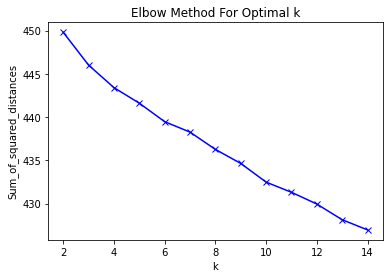

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Decide the best K

Besides the elbow method, you may need to read how data is being clustered and name the clusters accordingly. For this case, I am going for 10 clusters.

In [23]:
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_

data = {
        column_name__open_responses: df[column_name__open_responses].tolist()
        , 'labels': labels
}
df_cl=pd.DataFrame(data)
df_cl.sort_values(by='labels')


,reviewText,labels
249,Well if this review survives the censors just ...,0
248,"There are other rack screws out there, but Rax...",0
247,"Other than that, when you need 10-32 rack scre...",0
246,Great rack mount screws. Rubber washers are pe...,0
245,Donr be fooled by the imitations... should be ...,0
...,...,...
136,Hosa patch cables are the best for the buck. G...,8
304,Probably the best kapo out on the market. Very...,8
149,As expected from Hosa another great product. ...,8
71,...unbalanced guitar cable is notoriously nois...,8


# Evaluate the result

A nice way to evaluate the clustering is to create a word cloud from the articles of each cluster.

Cluster: 0
reviewText
Got a packet to try but I found they are better...
Good quality rack screws that come with rubber ...
Excellent rack screws with washers. Its fit ver...
Pros:* They look very nice.* They cause much le...
I replaced all the stock mounting screws that c...
Donr be fooled by the imitations... should be t...
Great rack mount screws. Rubber washers are per...
Other than that, when you need 10-32 rack screw...
There are other rack screws out there, but Raxx...
Well if this review survives the censors just k...


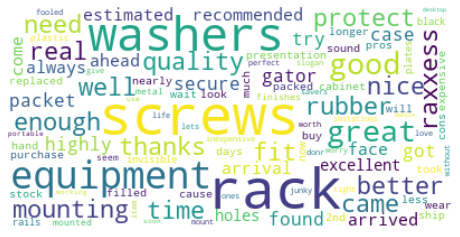

Cluster: 1
reviewText
The product does exactly as it should and is qu...
This pop filter is great. It looks and performs...
So good that I bought another one.  Love the he...
I love it, I used this for my Yamaha ypt-230 an...
wanted it just on looks alone...It is a nice lo...
This is a cool looking cheap cable which works ...
The Fender 18 Feet California Clear Instrument ...
Very good cable. Well made and it looks great w...
Got this cable to run a rockband keyboard contr...
Just trying to find a midi to midi was a task, ...
Use it every week at gigs.  Solid, no problems ...
This was exactly what I was after. I have a voi...
This cable seems like it will last me for a whi...
This is a fine cable at a decent price point, n...
Zero issues with this cable so far.  It feels f...
Realtively inexpensive patch cable for electric...
I bought this because I wanted a cheap replacem...
This is a very nice cable for the price. I alre...
Cheap and good texture rubber that does not get...
Seems stu

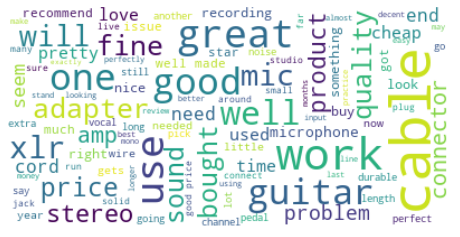

Cluster: 2
reviewText
I got it to have it if I needed it. I have foun...
If you are not use to using a large sustaining ...
I bought this to use in my home studio to contr...
I bought this to use with my keyboard. I wasn't...
I've been using these for about 3 weeks now - t...
I'm a pro-cheapo and I hated this thing. They'r...
This is not the fanciest cable you can buy, but...
This thing is like a magic Spray! Hah!Seriously...
Back in the 1980's I bought a can of deoxit(not...
Seriously?  The Shure SM57 sets the standard, w...
How do you review an SM58?? I've used these mos...
There are plenty of flashier - prettier - moder...
So far the ones I have used have all threaded n...
Hey, it gets the job done and that's all I can ...
This capo is as good as I've ever used and its ...
I bought a 12 string one in blk.  Love it for s...
I am very pleased with this purchase. The strin...
I have an electro acoustic Martin (second hand ...
I really like these things.  I don't stick tape...
I like th

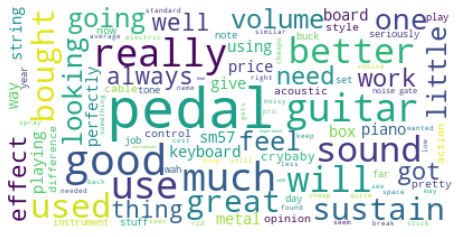

Cluster: 3
reviewText
This L Jack is good enough to make connections ...
This microphone is great for singing with a PA ...
It is exactly what you need in a capo! You can ...
The title says it all.  I got it for $16 (free ...
Quick to clip on and off. Really... Is there an...
Like this camo capo's simplicity and its unique...
Purchased the 6-string Kyser capo when I meant ...
I've seen and used many different types of capo...
Got what I needed - a basic capo for a good pri...
I've played guitar for 5 years. Seen many diffe...
What's to say?  It's not a high end capo and fo...
I originally bought this for my guitar and it w...
This style of capo CAN throw your guitar out of...
I can only repeat what everyone else has alread...
I don't believe there is such a thing as a perf...
I have used a few different capo's this is far ...
It does what it says. It a Kyser Quick Change c...
It's a capo... nice fit... yet, sometimes I won...
I bought this Capo for myWashburn D10. It works...
Easy to u

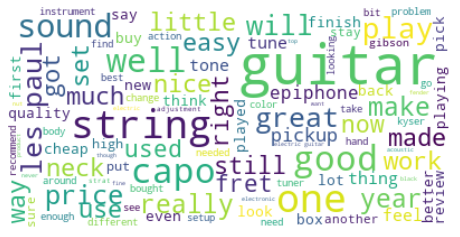

Cluster: 4
reviewText
Perfect for my Epiphone Sheraton II.  Monster c...
When I was searching for MIDI cables for my ART...
I bought these to go from my board to the amp. ...
These are not the greatest but they're cheap an...
I am not hard on cables.  I typically just plug...
These cables have taken a beating the last few ...
Hosa guitar cables work great. Never had any pr...
This item is well built and I like the terminal...
Hosa cable quality can be all over the place, s...
These are Good cables at a good price!! Not sur...
very sturdy, high quality with little to no fee...
I own lots of hosa cables they are cheap and qu...
Cables are cables. They usually all work. And w...
If you need some 6" cables to connect your peda...
These are great cables. The only con I could gi...
These are great patch cables especially for the...
these cable came super fast in the mail, They d...
I typically use planet waves cables but tried t...
Really just some inexpensive and yet durable ca...
If I didn

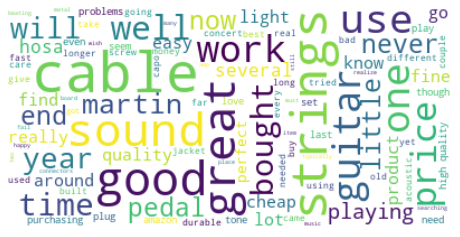

Cluster: 5
reviewText
I actually replaced a BOSS TR2 with this pedal....
When I first started setting up my little studi...
Love these capos and nice that you can get them...
I purchased this for my pedalboard a few years ...
I bought this little pedal back in 1996, about ...
First, let me start by saying this pedal has be...
The Boss CS3 is right for me, I have been using...
It really pains me to give anything but a 5-sta...
Guitarists have become a bunch of cork-sniffers...
Think of this as an artist's tool.  And for eve...
I have had this pedal for about 15 years, just ...
This pedal is a must have for any pedal board. ...
This was the first pedal I ever bought when I s...
This is a cheap piece of junk that does what it...
This is a distortion pedal. It will give your a...
I find that if I play this pedal along with my ...
This pedal has been on the market for a very lo...
From Greg Abrams review, entitled "For all but ...
Here's the deal with this pedal. It is inexpens...
This is a

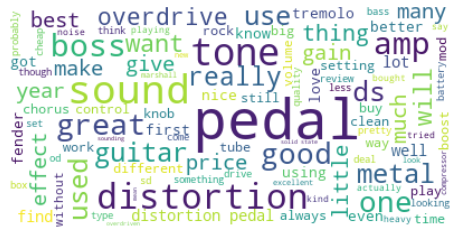

Cluster: 6
reviewText
Not much to write about here, but it does exact...
The primary job of this device is to block the ...
Nice windscreen protects my MXL mic and prevent...
I now use this cable to run from the output of ...
Fender cords look great and work just as well. ...
Hosa products are a good bang for the buck. I h...
I bought these because I really had too long of...
This amp plug is great for the price its 10 ft ...
I never really considered a cheaper cable, I wa...
One end was loose, so I tightened it, it keeps ...
I bought this for my Canon Vixia HF G10 Video C...
First, the reasons why I awarded this five star...
On my mixer, I have send/returns on the same pl...
I still operate in an analog environment quite ...
I use these in my home studio as INSERTS and th...
I carry this in my bass gig bag so I can plug m...
These have a lower profile and can fit and bend...
I got 3 of these to plug XLR cables into the 1/...
This Dual splitter works perfect. I own a live ...
This was 

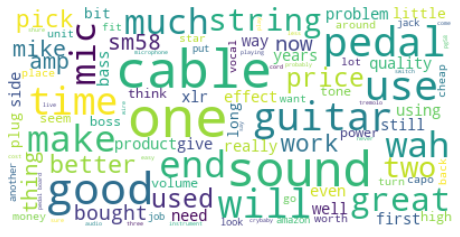

Cluster: 7
reviewText
I purchased this to work with my ION system and...
This converts an xlr signal (for me, a Shure SM...
For the money, this karaoke mic does a decent j...
We bought this Mic and a spare for our son's gu...
We bought this mic after seeing how our grandso...
The Gain on this mic isn't the greatest, but fo...
good mic for simple live stuff that isn't too e...
This is a proven classic.  Using it to mic my M...
Although this mic is now considered primarily a...
There's a reason every mic cabinet has at least...
I use this to mic snare drums and sometimes gui...
Considering that the SM57 was introduced to the...
This mic is well made (heavy on the mic-end).  ...
I bought this for my teen son for Christmas. He...
these are my preferred mics for practice and gi...
It is not a bad mic for the price ( If you want...
The first rule of microphones is that, "No one ...
Great all around mic used for vocals.  No frill...
This mic works better for some people than othe...
In the im

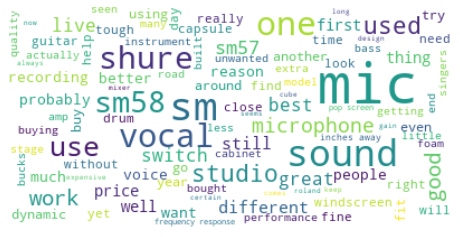

Cluster: 8
reviewText
I have used monster cables for years, and with ...
Monster makes the best cables and a lifetime wa...
Monster makes a wide array of cables, including...
This Fender cable is the perfect length for me!...
I've been using these cables for more than 4 mo...
Cant go wrong. Great quality on a budget price ...
The ends of the midi cable look and feel like q...
The Hosa XLR cables are affordable and very hea...
Sturdy cord and plugs, inexpensive, good value....
I've used a lot of cables and I always come bac...
I bought this cord after returning a cheap one ...
Nice solid cables, with excellent support at th...
           Good quality cable and sounds very good
This Hosa Cable is very well made, with good qu...
It hums, crackles, and I think I'm having probl...
I have found Hosa cables to be an excellent val...
This is good cable. Excellent 1/4&#34; plugs. T...
I use this cord in my church to run from my ped...
This my second Hosa guitar cable.  (The other o...
In my opi

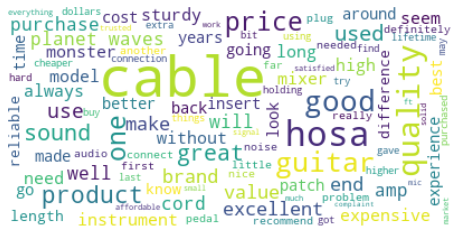

In [24]:
from wordcloud import WordCloud

for k in range(0,true_k):
   s=df_cl[df_cl['labels']==k]
   text=s[column_name__open_responses].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print(column_name__open_responses)
   responses=df_cl[df_cl.labels==k][column_name__open_responses]         
   print(responses.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()
